## 1.Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle
from tkinter import *
from tkinter import messagebox
from sklearn.metrics import root_mean_squared_error


## 2.Load and Explore the Data

In [2]:
calories = pd.read_csv('calories.csv')
exercise = pd.read_csv('exercise.csv')
data = pd.merge(calories, exercise, on='User_ID')

### Overview of the dataset

In [3]:
data.head()

User_ID  Calories  Gender  Age  Height  Weight  Duration  Heart_Rate  \
0  14733363     231.0    male   68   190.0    94.0      29.0       105.0   
1  14861698      66.0  female   20   166.0    60.0      14.0        94.0   
2  11179863      26.0    male   69   179.0    79.0       5.0        88.0   
3  16180408      71.0  female   34   179.0    71.0      13.0       100.0   
4  17771927      35.0  female   27   154.0    58.0      10.0        81.0   

   Body_Temp  
0       40.8  
1       40.3  
2       38.7  
3       40.5  
4       39.8

### Dataset information

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Calories    15000 non-null  float64
 2   Gender      15000 non-null  object 
 3   Age         15000 non-null  int64  
 4   Height      15000 non-null  float64
 5   Weight      15000 non-null  float64
 6   Duration    15000 non-null  float64
 7   Heart_Rate  15000 non-null  float64
 8   Body_Temp   15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


### Basic statistics of numerical columns

In [5]:
data.describe()

User_ID      Calories           Age        Height        Weight  \
count  1.500000e+04  15000.000000  15000.000000  15000.000000  15000.000000   
mean   1.497736e+07     89.539533     42.789800    174.465133     74.966867   
std    2.872851e+06     62.456978     16.980264     14.258114     15.035657   
min    1.000116e+07      1.000000     20.000000    123.000000     36.000000   
25%    1.247419e+07     35.000000     28.000000    164.000000     63.000000   
50%    1.499728e+07     79.000000     39.000000    175.000000     74.000000   
75%    1.744928e+07    138.000000     56.000000    185.000000     87.000000   
max    1.999965e+07    314.000000     79.000000    222.000000    132.000000   

           Duration    Heart_Rate     Body_Temp  
count  15000.000000  15000.000000  15000.000000  
mean      15.530600     95.518533     40.025453  
std        8.319203      9.583328      0.779230  
min        1.000000     67.000000     37.100000  
25%        8.000000     88.000000     39.600000  
50%       16.000000     96.000000     40.200000  
75%       23.000000    103.000000     40.600000  
max       30.000000    128.000000     41.500000

## 3.Perform EDA (Exploratory Data Analysis)

### Heatmap for Correlation Matrix

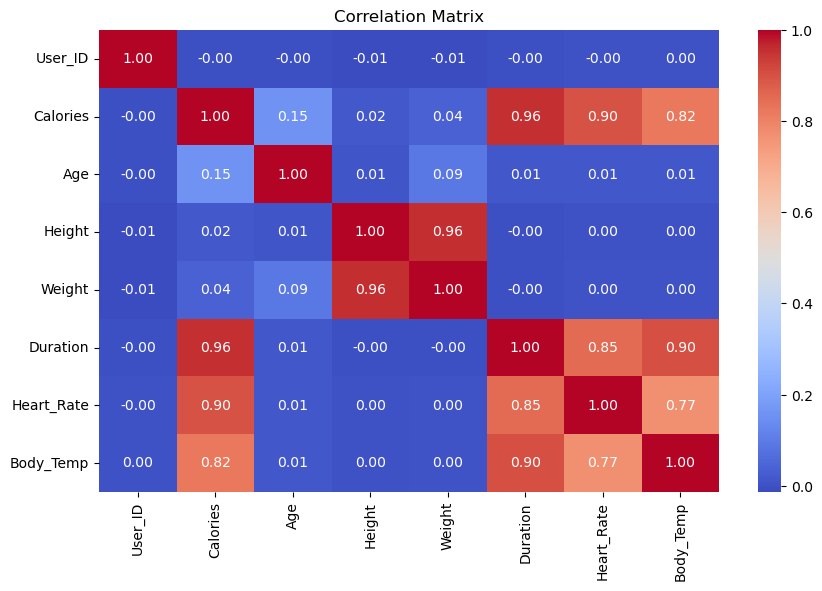

In [6]:
numeric_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


### Pairplot for Numerical Columns

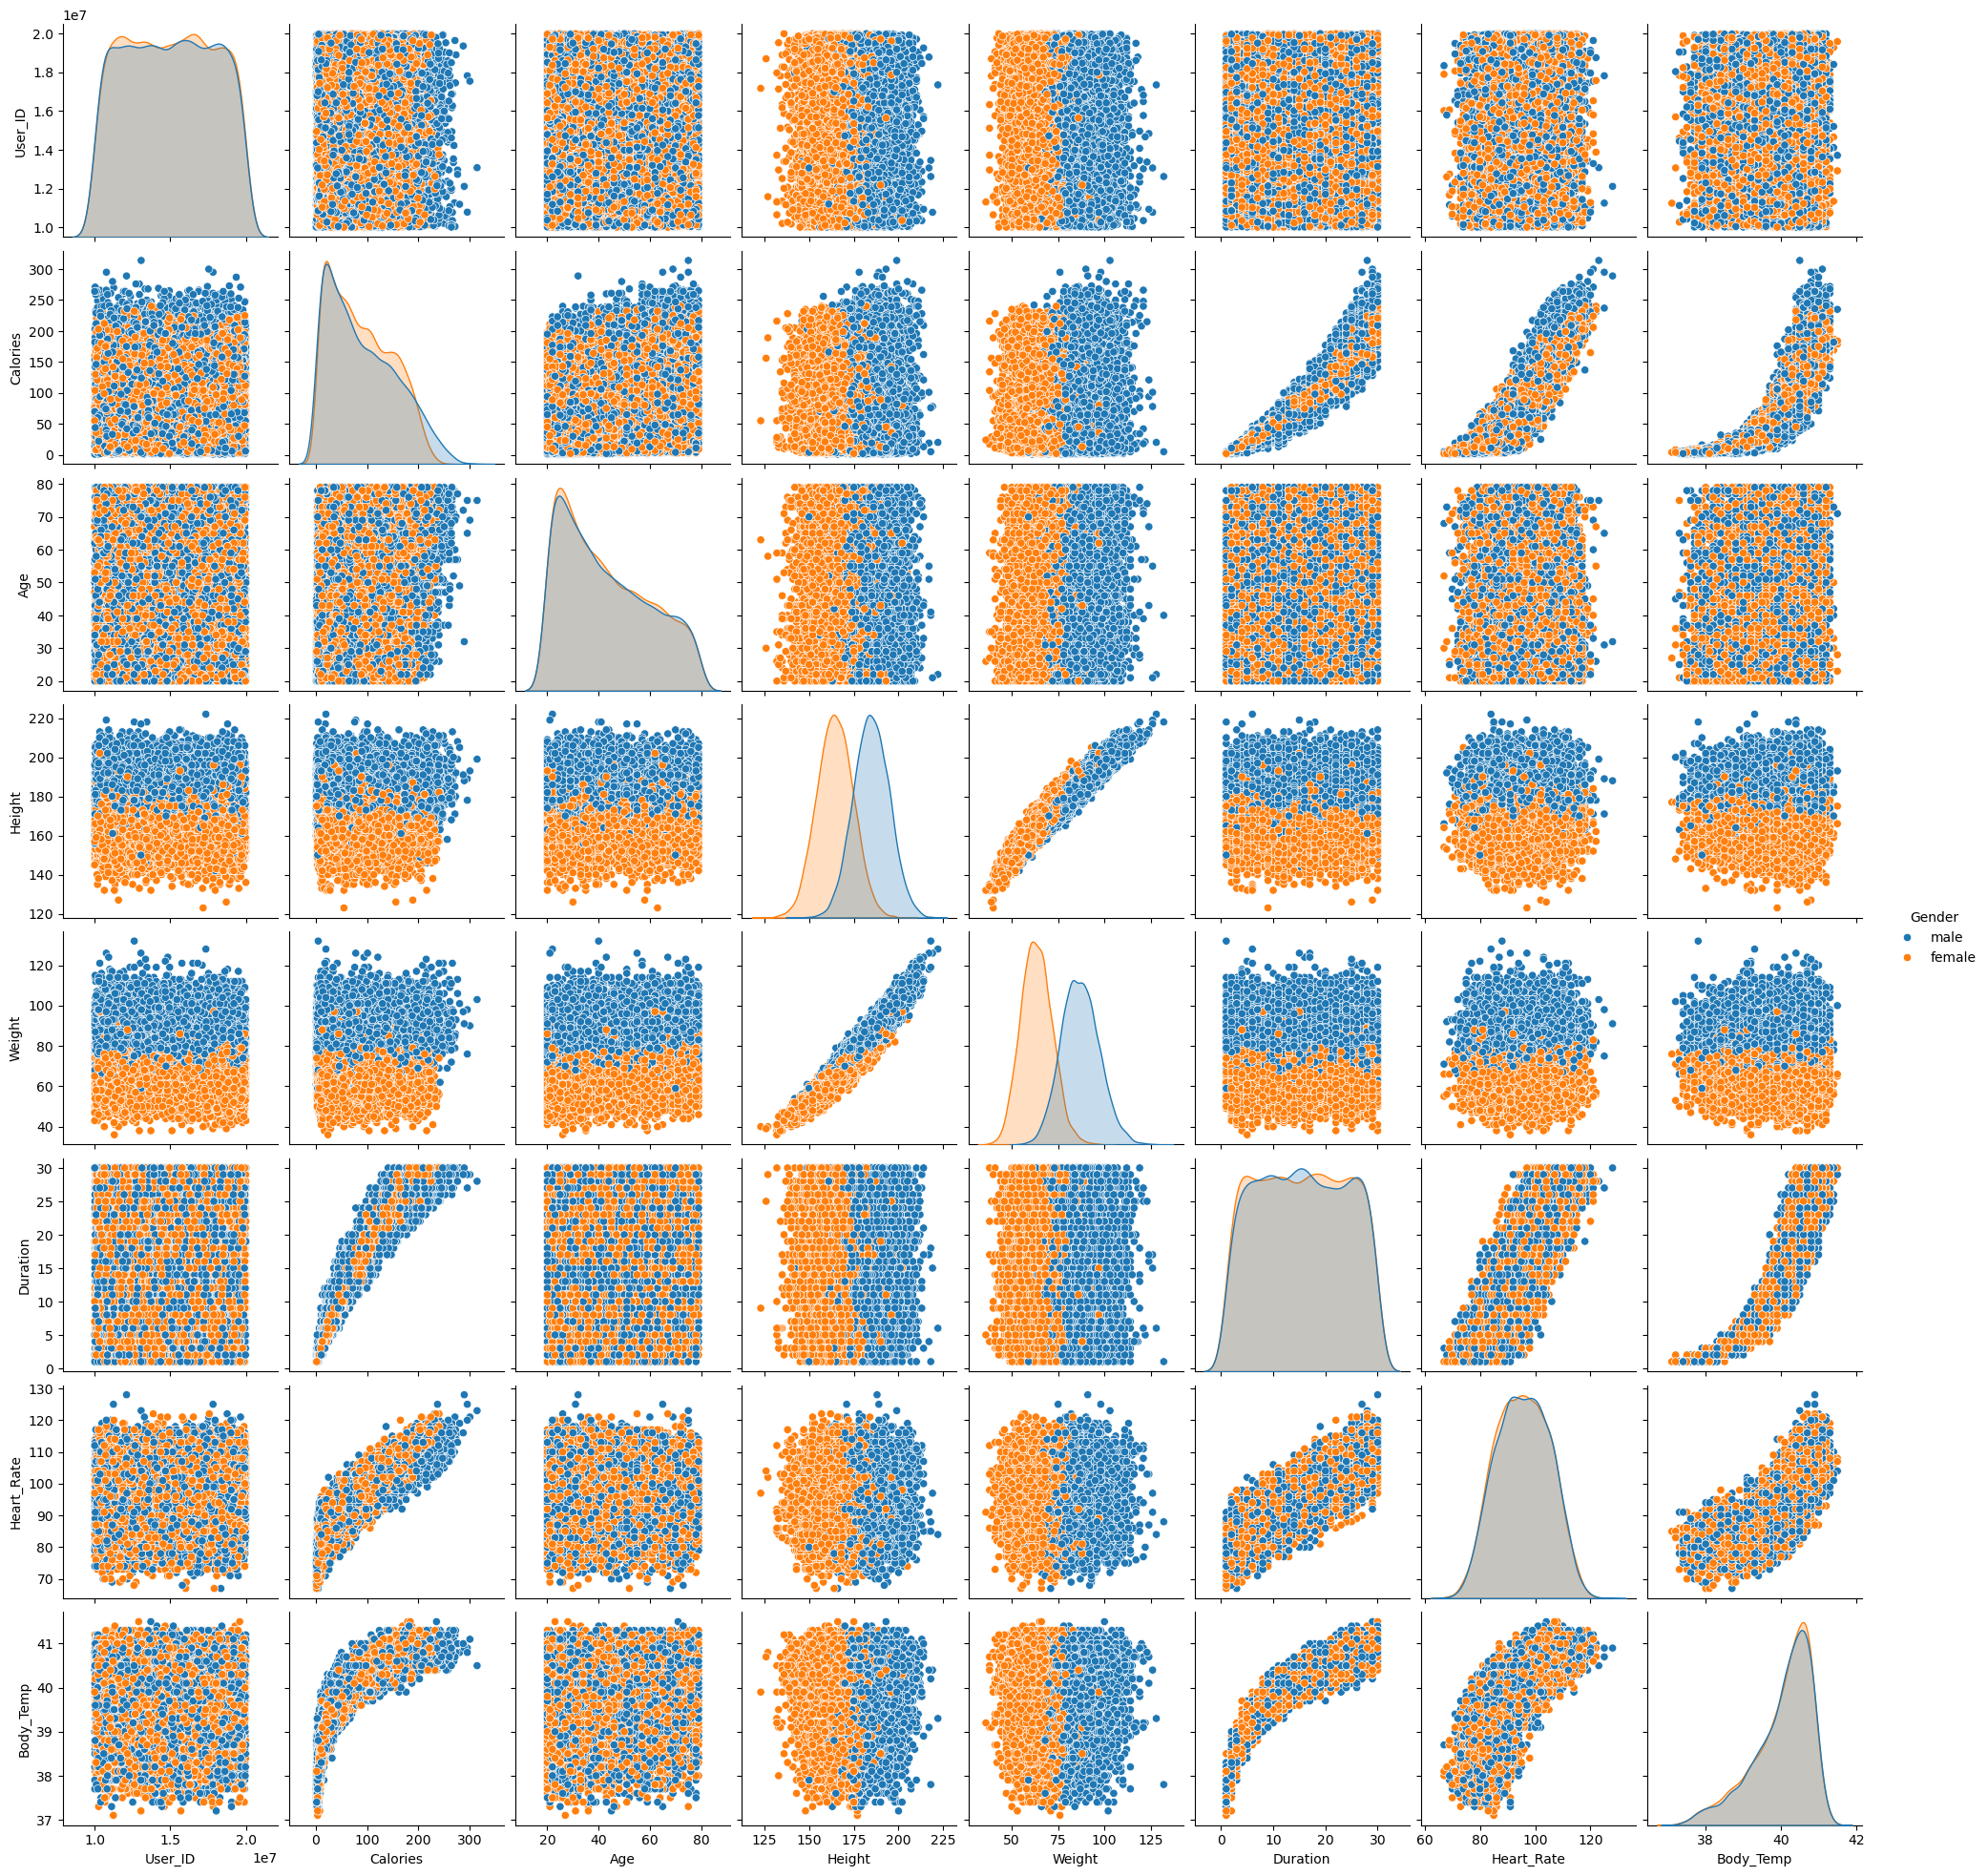

In [7]:
sns.pairplot(data, diag_kind='kde', hue='Gender')
plt.show()

## 4.Data Preparation

### Splitting Features and Target

In [8]:
X = data.drop(columns=['User_ID', 'Calories'], axis=1)
y = data['Calories']

### Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Preprocessing Pipeline

In [10]:
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', OrdinalEncoder(), ['Gender']),
    ('num', StandardScaler(), ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']),
], remainder='passthrough')

## 5.Model Evaluation Function

In [11]:
def evaluate_model(model_name, model, param_grid=None):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        pipeline.fit(X_train, y_train)
        best_model = pipeline

    y_pred = best_model.predict(X_test)

    metrics = {
        'Model': model_name,
        'R2 Score': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred)
    }

    return metrics, best_model

## 6.Define Model Parameters for Tuning

In [12]:
rf_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5]
}

xgb_param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 5, 7]
}

# Linear Regression has no direct tunable hyperparameters, but its extensions like Ridge, Lasso, or ElasticNet include regularization parameters that can be tuned.

## 7.Evaluate and Compare Models

In [13]:
metrics_rf, best_rf_model = evaluate_model('Random Forest', RandomForestRegressor(), rf_param_grid)
metrics_xgb, best_xgb_model = evaluate_model('XGBoost', XGBRegressor(), xgb_param_grid)
metrics_lr, best_lr_model = evaluate_model('Linear Regression', LinearRegression())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


## 8.Display Model Performance

### Combine Metrics

In [14]:
all_metrics = pd.DataFrame([metrics_lr, metrics_rf, metrics_xgb])
print("\nModel Performance:\n", all_metrics)


Model Performance:
                Model  R2 Score       MAE       RMSE      MAPE
0  Linear Regression  0.967294  8.441514  11.488940  0.292178
1      Random Forest  0.998272  1.677115   2.640850  0.026154
2            XGBoost  0.999314  1.188951   1.663583  0.024853


###### R2 Score : Higher is better, as it indicates how well the model explains the variance in the target variable.
###### MAE (Mean Absolute Error) : Lower is better, as it measures the average absolute difference between predicted and actual values.
###### RMSE (Root Mean Squared Error) : Lower is better, as it penalizes larger errors more than MAE and reflects model accuracy.
###### MAPE (Mean Absolute Percentage Error) : Lower is better, as it shows the average percentage error between predictions and actual values.

### Visualize Metrics

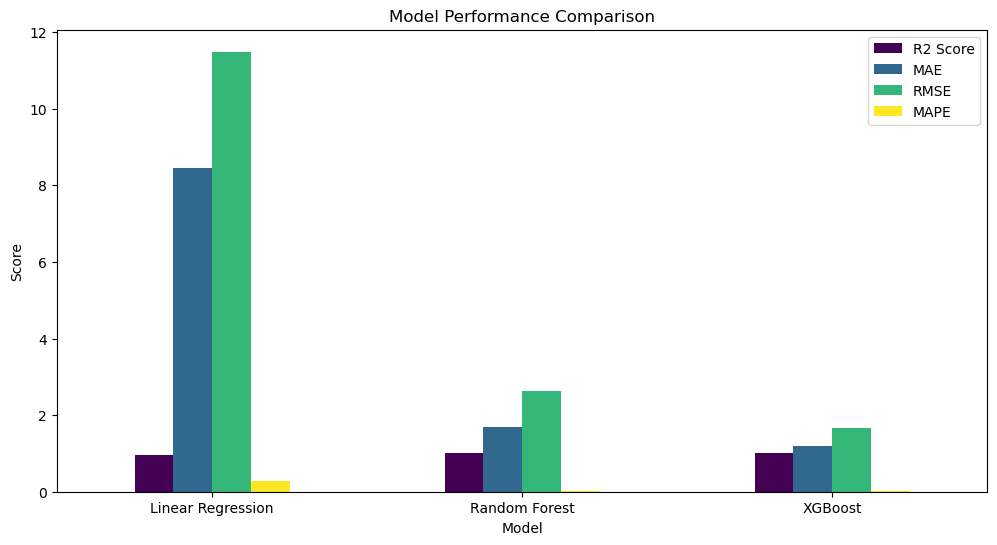

In [15]:
all_metrics.set_index('Model')[['R2 Score', 'MAE', 'RMSE', 'MAPE']].plot(kind='bar', figsize=(12, 6), colormap='viridis', rot=0)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

## 9.Save the Best Model Pipeline

In [16]:
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

## 10.GUI for Predictions

In [17]:
def show_entry():
    with open('pipeline.pkl', 'rb') as f:
        pipeline = pickle.load(f)

    p1 = str(clicked.get())
    p2 = float(e2.get())
    p3 = float(e3.get())
    p4 = float(e4.get())
    p5 = float(e5.get())
    p6 = float(e6.get())
    p7 = float(e7.get())

    sample = pd.DataFrame({
        'Gender': [p1],
        'Age': [p2],
        'Height': [p3],
        'Weight': [p4],
        'Duration': [p5],
        'Heart_Rate': [p6],
        'Body_Temp': [p7],
    }, index=[0])

    result = pipeline.predict(sample)
    Label(master, text="Amount of Calories Burnt").grid(row=13)
    Label(master, text=result[0]).grid(row=14)

## 11.Build the GUI Application

In [ ]:
master = Tk()
master.title("Calories Burnt Prediction using Machine Learning")
label = Label(master, text="Calories Burnt Prediction", bg="black", fg="white").grid(row=0, columnspan=2)

Label(master, text="Select Gender", bg="#c39fd9", font=("Tahoma", 10)).grid(row=1)
Label(master, text="Enter Your Age", bg="#c39fd9", font=("Tahoma", 10)).grid(row=2)
Label(master, text="Enter Your Height (cm)", bg="#c39fd9", font=("Tahoma", 10)).grid(row=3)
Label(master, text="Enter Your Weight (kg)", bg="#c39fd9", font=("Tahoma", 10)).grid(row=4)
Label(master, text="Duration", bg="#c39fd9", font=("Tahoma", 10)).grid(row=5)
Label(master, text="Heart Rate", bg="#c39fd9", font=("Tahoma", 10)).grid(row=6)
Label(master, text="Body Temp", bg="#c39fd9", font=("Tahoma", 10)).grid(row=7)

master.configure(bg="#c39fd9")

clicked = StringVar()
options = ['male', 'female']

e1 = OptionMenu(master, clicked, *options)
e1.configure(width=13)
e2 = Entry(master)
e3 = Entry(master)
e4 = Entry(master)
e5 = Entry(master)
e6 = Entry(master)
e7 = Entry(master)

e1.grid(row=1, column=1)
e2.grid(row=2, column=1)
e3.grid(row=3, column=1)
e4.grid(row=4, column=1)
e5.grid(row=5, column=1)
e6.grid(row=6, column=1)
e7.grid(row=7, column=1)

Button(master, text="Predict", command=show_entry).grid()
mainloop()